## Skin Cancer Classification Project

## Installing and Importing Dependencies

In [ ]:
import time
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

: 

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn.metrics import confusion_matrix

The labels for the dataset are binary `[0, 1]`, which corresponds to whether an image is Benign or Malignant.

<table>
    <tr>
        <th>Label</th>
        <th>Class</th>
    </tr>
    <tr>
        <td>0</td>
        <td>Benign</td>
    </tr>
    <tr>
        <td>1</td>
        <td>Malignant</td>
    </tr>
</table>

### Setting up the path for the Training, Validation and Test sets.

In [3]:
base_dir = 'C:/Users/Qoojo/Desktop/data'
train_dir = 'C:/Users/Qoojo/Desktop/data/train'
valid_dir = 'C:/Users/Qoojo/Desktop/data/valid'
test_dir = 'C:/Users/Qoojo/Desktop/data/test'

In [4]:
# directory with our training malignant images
train_malignant_dir = 'C:/Users/Qoojo/Desktop/data/train/malignant'
# directory with our training benign images
train_benign_dir = 'C:/Users/Qoojo/Desktop/data/train/benign'

# directory with our validation malignant images
valid_malignant_dir = 'C:/Users/Qoojo/Desktop/data/valid/malignant'
# directory with our validation benign images
valid_benign_dir = 'C:/Users/Qoojo/Desktop/data/valid/benign'

# directory with our test malignant images
test_malignant_dir = 'C:/Users/Qoojo/Desktop/data/test/malignant'
# directory with our test benign images
test_benign_dir = 'C:/Users/Qoojo/Desktop/data/test/benign'


In [ ]:
train_examples = test_examples = validation_examples = 0
for line in open("C:/Users/Qoojo/Desktop/data/labels.csv").readlines()[1:]:
    split_line = line.split(',')
    img_file = split_line[0]
    target = split_line[1]

    random_num = random.random()

    if random_num < 0.8:
        location = train_dir
        train_examples += 1
    elif random_num < 0.9:
        location = valid_dir
        validation_examples += 1
    else:
        location = test_dir
        test_examples += 1

    if int(float(target)) == 0:
        shutil.move(
            "C:/Users/Qoojo/Desktop/data/" + img_file + ".jpg",
            location + "/benign/" + img_file + ".jpg",
        )
    elif int(float(target)) == 1:
        shutil.move(
            "C:/Users/Qoojo/Desktop/data/" + img_file + ".jpg",
            location + "/malignant/" + img_file + ".jpg",
        )

print(f"Training example: {train_examples}")
print(f"Validation example: {validation_examples}")
print(f"Test example: {test_examples}")


# Data Augmentation

To prevent overfitting and ensure the model does not see the same image twice, we perform image data augmentation. More data is generated from the existing training dataset by applying some random transformations to the images which helps the model to generalize better.

We create a `BATCH_SIZE` of 32 images and the training set will have `IMAGE_SHAPE`  of width 224 pixels and height of 224 pixels.

The value of each pixel in the image data is an integer in the range `[0,255]`. We need to rescale these values to the range `[0,1]` so that the model works well.

In [17]:
BATCH_SIZE = 32
IMAGE_SHAPE = 224

### Applying Random Transformations.

In the code cell below, we have applied rescale, random horizontal flip, random vertical flip, random zoom, random rotation, and other transformations to our training dataset.

In [18]:
image_generator_train = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

train_data_generator = image_generator_train.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode='binary')

Found 8030 images belonging to 2 classes.


In [19]:
# This function is used to plot images in a grid form with 1 row and 5 columns.

def plotImages(images_array):
    fig, axes = plt.subplots(1, 5, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_array, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

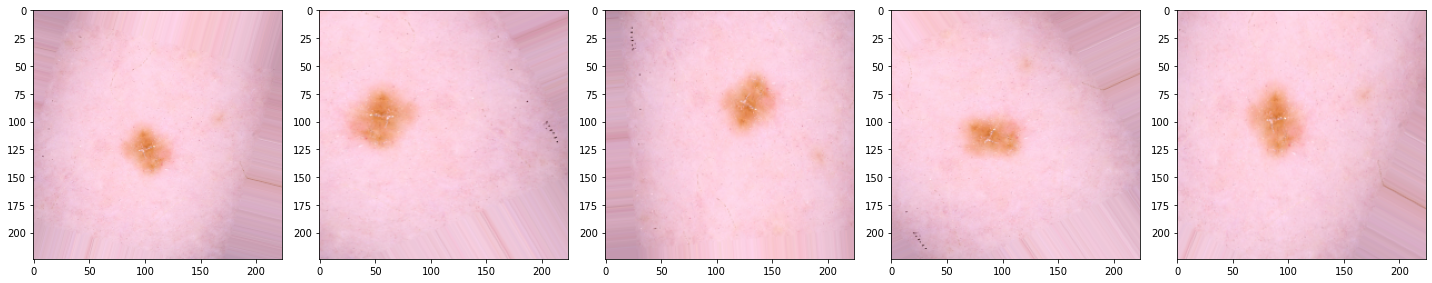

In [20]:
# To see data augmentation in action, we apply all these transformations to an image from the training data 5 times.

augmented_images = [train_data_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Data Generator for the Validation Set

We use ImageDataGenerator to create a transformation that rescales the images by 255.

In [21]:
image_gen_valid = ImageDataGenerator(rescale=1.0/255)

valid_data_generator = image_gen_valid.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=valid_dir,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode='binary')


Found 1009 images belonging to 2 classes.


### Data Generator for the Test Set

We use ImageDataGenerator to create a transformation that rescales the images by 255.

In [22]:
image_gen_test = ImageDataGenerator(rescale=1.0/255)

test_data_generator = image_gen_test.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=test_dir,
    target_size=(IMAGE_SHAPE, IMAGE_SHAPE),
    class_mode='binary')


Found 961 images belonging to 2 classes.


# Transfer learning with MobileNet v2

We'll be using MobileNet v2 and retrain some of the layers with our own dataset.

In [23]:
feature_extractor = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
    trainable=False,
    input_shape=(IMAGE_SHAPE, IMAGE_SHAPE, 3))

### Define the model and metrics

In [24]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
]

In [25]:
# We add a new classification layer.
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(1, activation='sigmoid')
  ])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


### Compiling the model

In [26]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

## Train the Model

In [27]:
EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

In [28]:
history_info = model.fit(
    train_data_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=valid_data_generator)


Epoch 1/100
251/251 [==============================] - 2728s 11s/step - loss: 0.2936 - tp: 3054.0000 - fp: 391.0000 - tn: 3991.0000 - fn: 594.0000 - accuracy: 0.8773 - precision: 0.8865 - recall: 0.8372 - auc: 0.9469 - prc: 0.9446 - val_loss: 0.2429 - val_tp: 429.0000 - val_fp: 83.0000 - val_tn: 481.0000 - val_fn: 16.0000 - val_accuracy: 0.9019 - val_precision: 0.8379 - val_recall: 0.9640 - val_auc: 0.9788 - val_prc: 0.9763
Epoch 2/100
251/251 [==============================] - 1967s 8s/step - loss: 0.2126 - tp: 3253.0000 - fp: 291.0000 - tn: 4091.0000 - fn: 395.0000 - accuracy: 0.9146 - precision: 0.9179 - recall: 0.8917 - auc: 0.9729 - prc: 0.9705 - val_loss: 0.1795 - val_tp: 416.0000 - val_fp: 42.0000 - val_tn: 522.0000 - val_fn: 29.0000 - val_accuracy: 0.9296 - val_precision: 0.9083 - val_recall: 0.9348 - val_auc: 0.9823 - val_prc: 0.9801
Epoch 3/100
251/251 [==============================] - 2040s 8s/step - loss: 0.1868 - tp: 3308.0000 - fp: 266.0000 - tn: 4116.0000 - fn: 340.0000

## Displaying Training Statistics

We use the `history` object to visualize how the model performs after each training epoch.

Here, we plot the model's accuracy and loss on the training and validation set which are useful for checking overfitting.

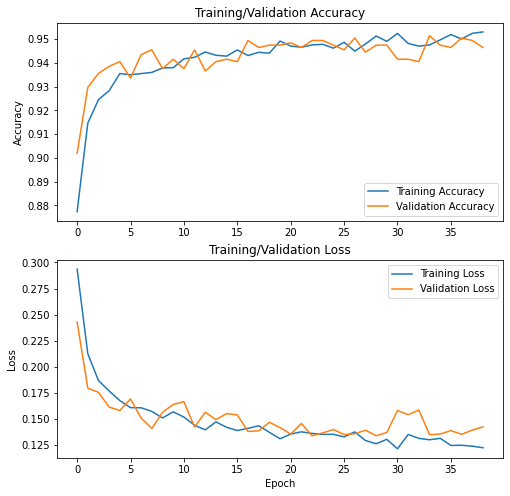

In [33]:
train_accuracy = history_info.history['accuracy']
valid_accuracy = history_info.history['val_accuracy']

train_loss = history_info.history['loss']
valid_loss = history_info.history['val_loss']

epochs_range = range(39)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, valid_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training/Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, valid_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training/Validation Loss')
plt.xlabel('Epoch')
plt.show()


In [44]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_", " ").capitalize()
    plt.subplot(2, 2, n+1)
    plt.plot(history.epoch,
             history.history[metric], label='Training')
    plt.plot(history.epoch, history.history['val_'+metric], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8, 1])
    else:
      plt.ylim([0, 1])

    plt.legend()

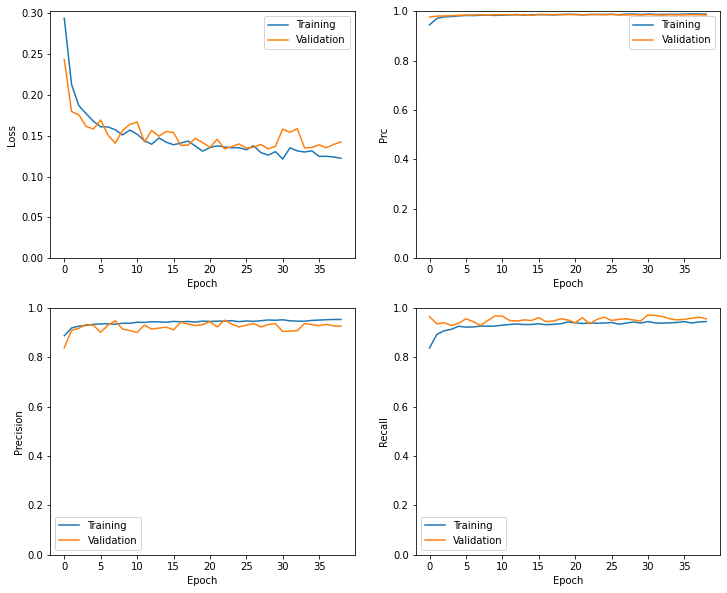

In [45]:
plot_metrics(history_info)

## Evaluating the Metrics

### Evaluating the model on the test dataset

In [211]:
results = model.evaluate(test_data_generator,
                          batch_size=BATCH_SIZE, verbose=0)
                          
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)

loss :  0.15423375368118286
tp :  400.0
fp :  30.0
tn :  502.0
fn :  29.0
accuracy :  0.9386056065559387
precision :  0.930232584476471
recall :  0.9324009418487549
auc :  0.9851552248001099
prc :  0.9815077185630798


In [210]:
# We take a batch of 32 images from the test set
image_batch, label_batch = next(test_data_generator)
result_batch = model.predict(image_batch)
prediction_batch = np.round(result_batch)

print('Actual Labels:\n', label_batch)
print('Predictions:\n', prediction_batch)

Actual Labels:
 [0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0.
 1. 1. 0. 0. 0. 1. 0. 0.]
Predictions:
 [[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


# Exporting as a SavedModel

In [90]:
t = time.time()
export_dir = "./{}".format(int(t))
tf.keras.models.save_model(model, export_dir)

INFO:tensorflow:Assets written to: ./1636845158\assets


INFO:tensorflow:Assets written to: ./1636845158\assets
